# 11 - Decision tree on all spatial sections

In [1]:
import glob
import os
import pandas as pd
import scanpy as sc
import xgboost as xgb

from pylab import rcParams
from scipy.cluster.hierarchy import leaves_list, ward
from scipy.spatial.distance import pdist

In [2]:
%run ../scripts/helpers-spatial.py

In [3]:
model = xgb.XGBClassifier()
model.load_model("../data/processed/11_dt.model.json")

In [4]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=30, n_jobs=12, nthread=6,
              num_parallel_tree=1, random_state=12345, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=False, validate_parameters=True,
              verbosity=None)

In [5]:
features = list(model.get_booster().get_score().keys())

## Predict InterVE from Resolve slices

In [6]:
slices = glob.glob("../zenodo/spatial/processed/[A-Z][0-9]*")

Processing C1_4 ...


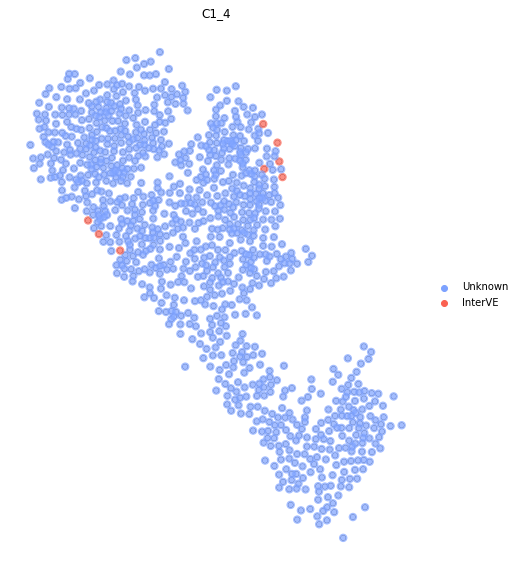

InvertVE cells: ['cell_71', 'cell_211', 'cell_223', 'cell_454', 'cell_558', 'cell_624', 'cell_669', 'cell_825']


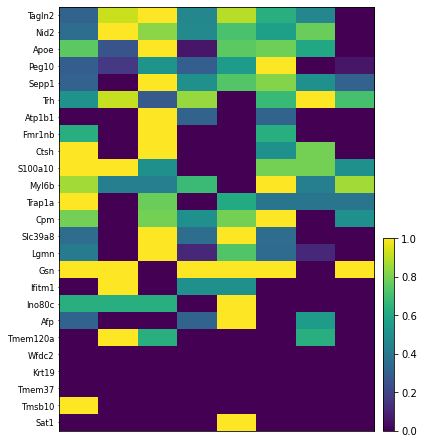

Processing B1_2 ...


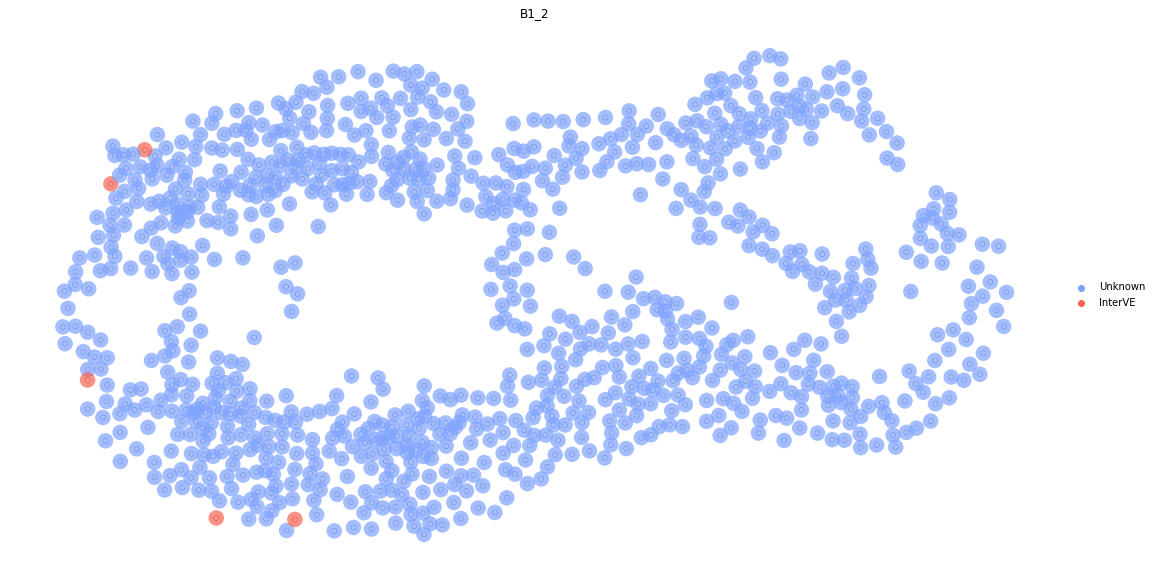

InvertVE cells: ['cell_199', 'cell_290', 'cell_456', 'cell_637', 'cell_671']


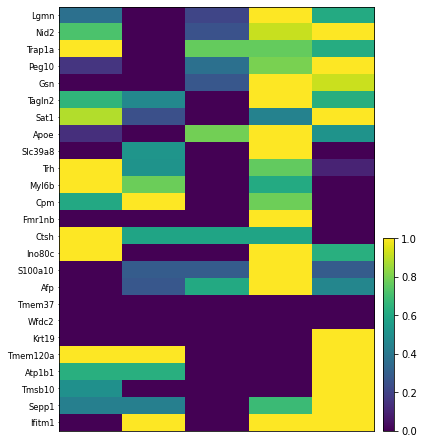

Processing D1_4 ...


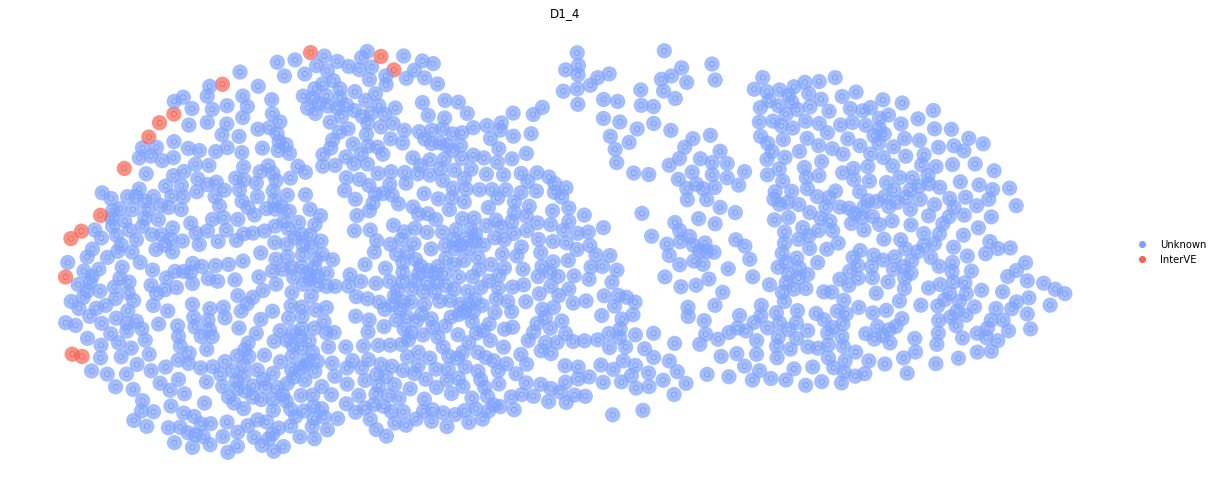

InvertVE cells: ['cell_27', 'cell_73', 'cell_135', 'cell_136', 'cell_205', 'cell_442', 'cell_461', 'cell_587', 'cell_614', 'cell_919', 'cell_1077', 'cell_1126', 'cell_1163', 'cell_1172']


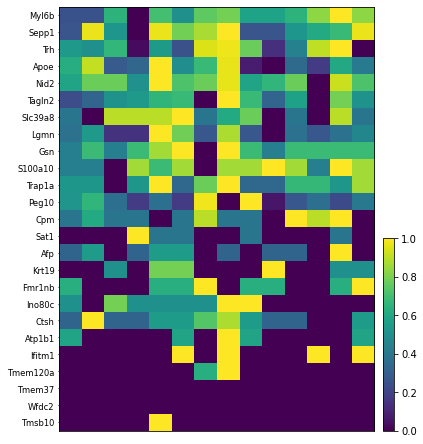

Processing D1_2 ...


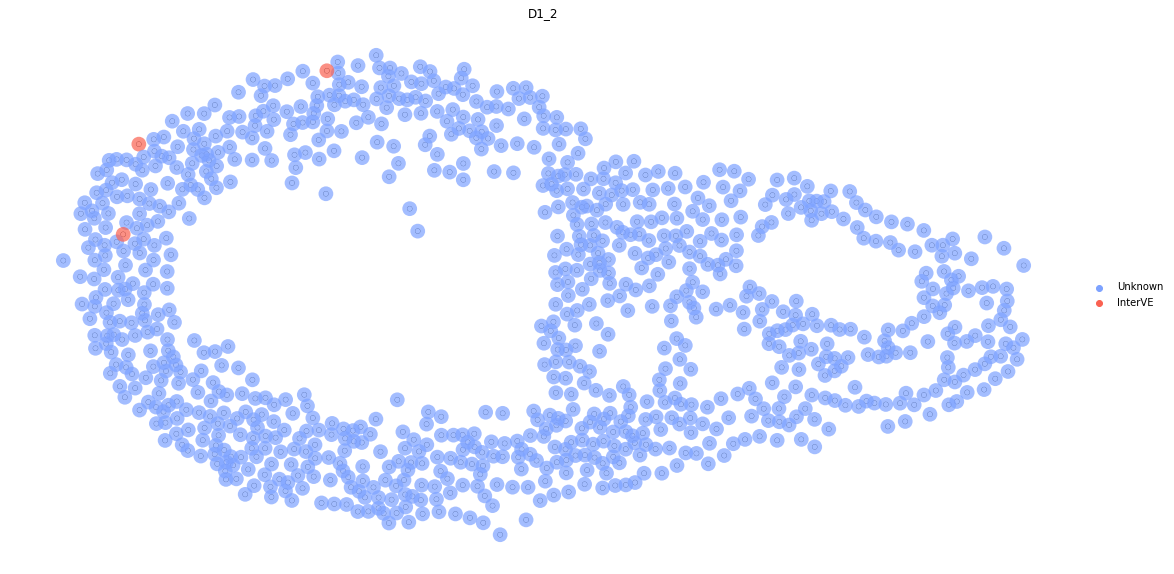

InvertVE cells: ['cell_496', 'cell_647', 'cell_809']


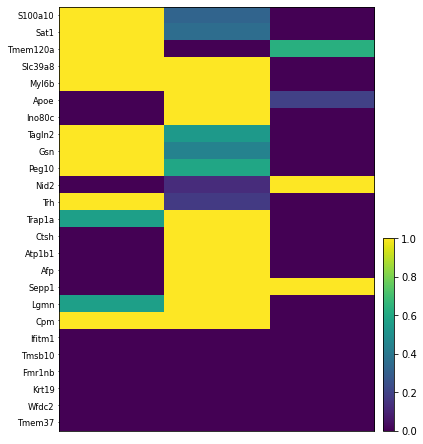

Processing A1_2 ...


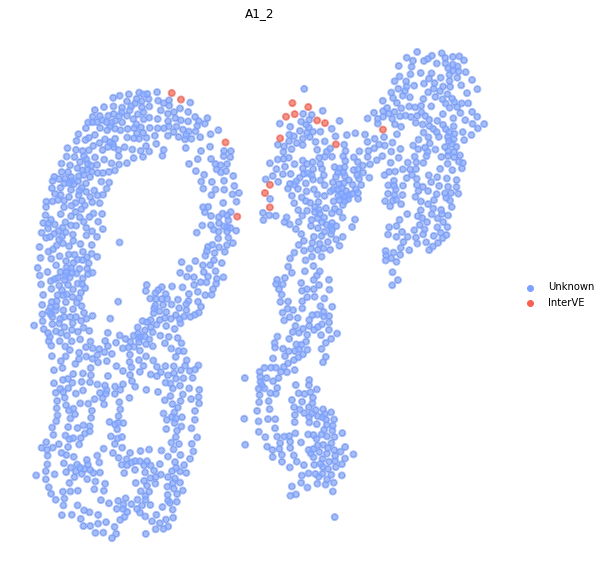

InvertVE cells: ['cell_16', 'cell_40', 'cell_148', 'cell_203', 'cell_228', 'cell_268', 'cell_354', 'cell_421', 'cell_426', 'cell_626', 'cell_746', 'cell_790', 'cell_963', 'cell_1188', 'cell_1230', 'cell_1334']


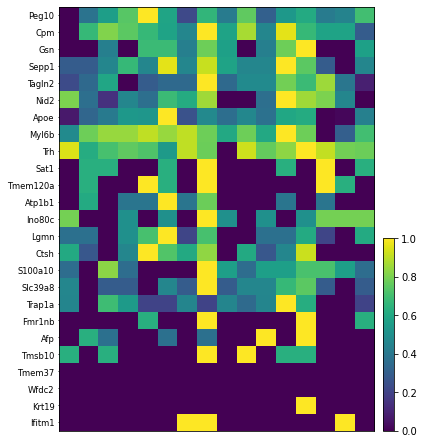

Processing C1_2 ...


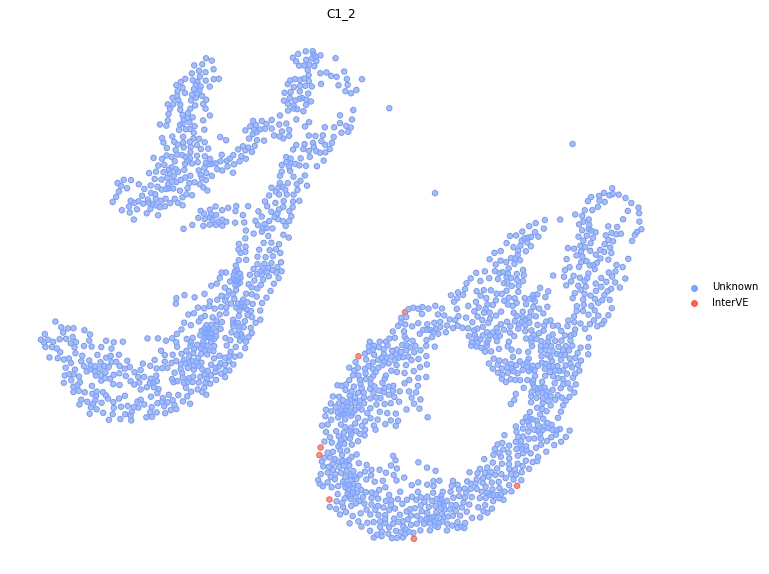

InvertVE cells: ['cell_21', 'cell_579', 'cell_916', 'cell_972', 'cell_1216', 'cell_1409', 'cell_1536']


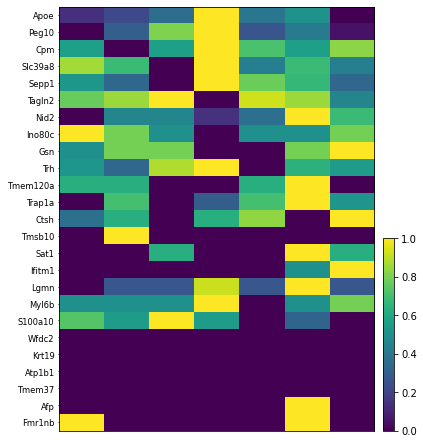

Processing A2 ...


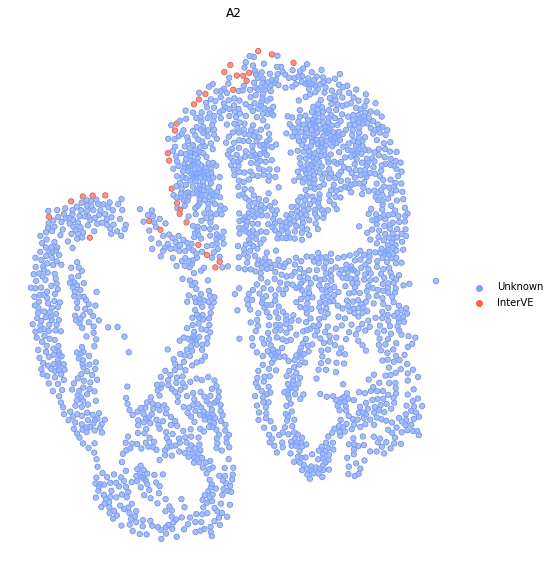

InvertVE cells: ['cell_209', 'cell_264', 'cell_413', 'cell_441', 'cell_495', 'cell_511', 'cell_654', 'cell_659', 'cell_797', 'cell_814', 'cell_850', 'cell_873', 'cell_907', 'cell_909', 'cell_1006', 'cell_1008', 'cell_1030', 'cell_1053', 'cell_1146', 'cell_1302', 'cell_1351', 'cell_1362', 'cell_1417', 'cell_1449', 'cell_1460', 'cell_1545', 'cell_1579', 'cell_1734', 'cell_1744', 'cell_1812', 'cell_1849', 'cell_2013', 'cell_2070', 'cell_2098']


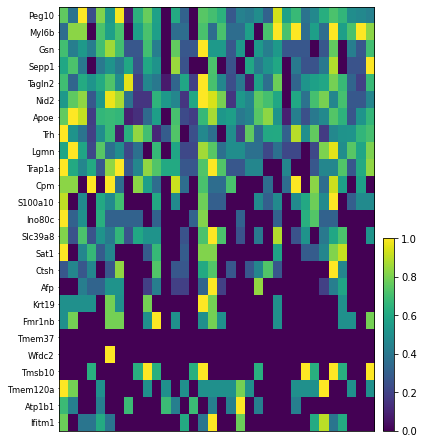

Processing C1_1 ...


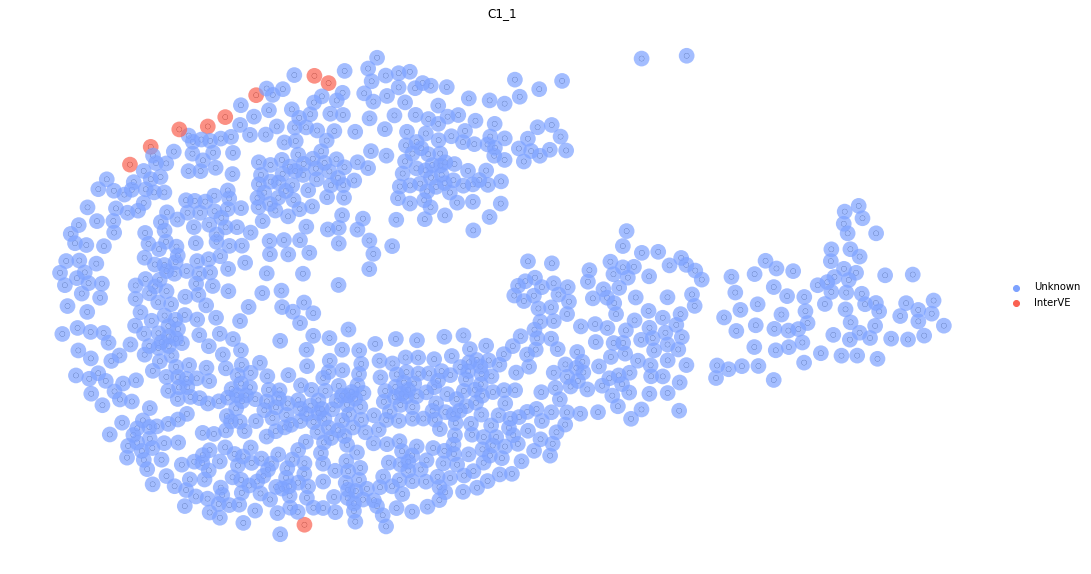

InvertVE cells: ['cell_166', 'cell_186', 'cell_212', 'cell_280', 'cell_323', 'cell_390', 'cell_509', 'cell_671', 'cell_906']


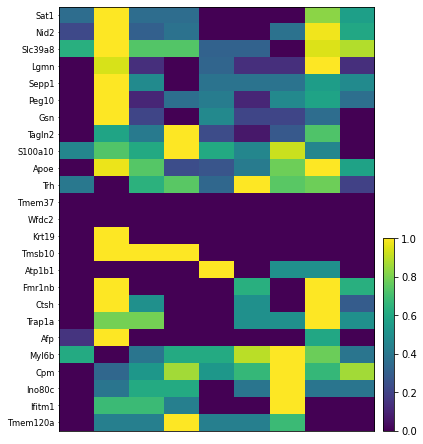

Processing A7 ...


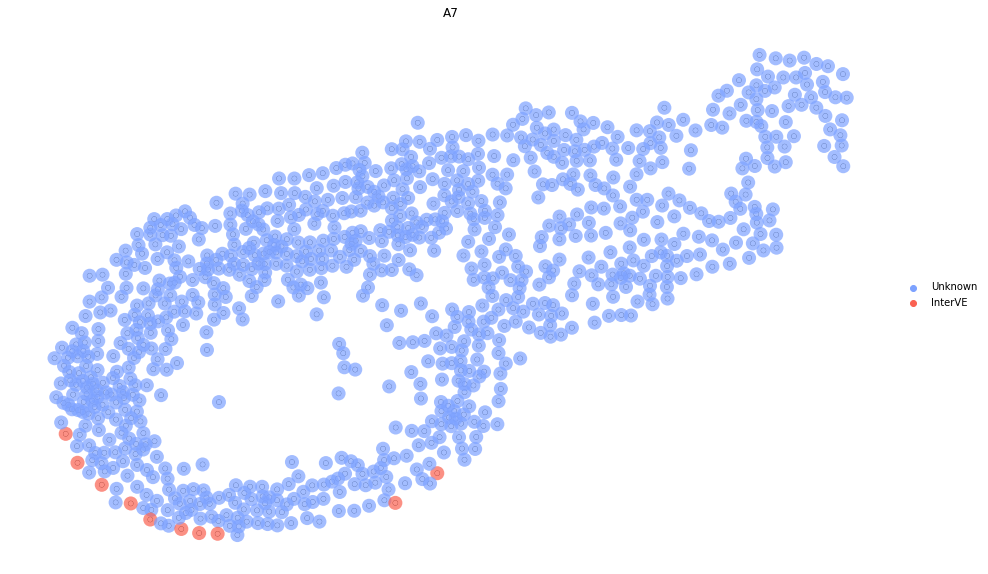

InvertVE cells: ['cell_108', 'cell_114', 'cell_136', 'cell_215', 'cell_434', 'cell_471', 'cell_485', 'cell_629', 'cell_677', 'cell_714']


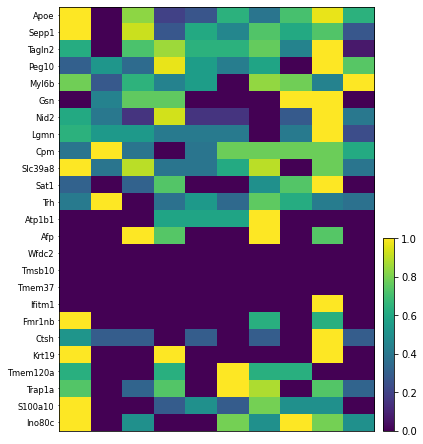

Processing C1_3 ...


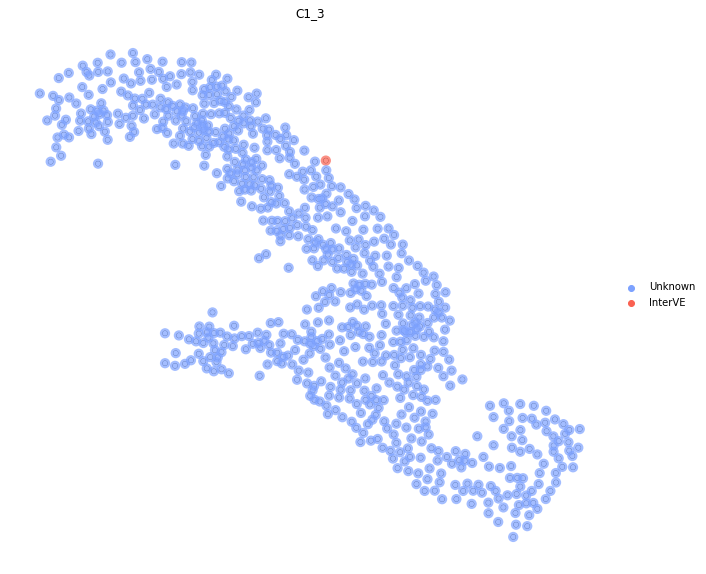

InvertVE cells: ['cell_76']


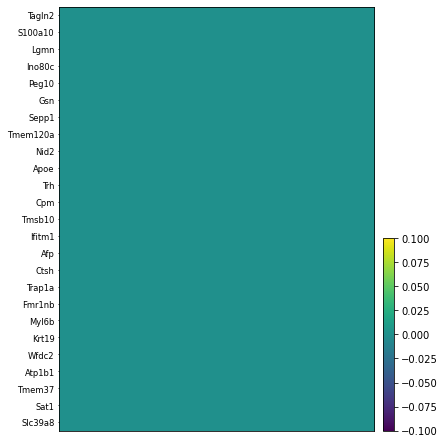

Processing A1_1 ...


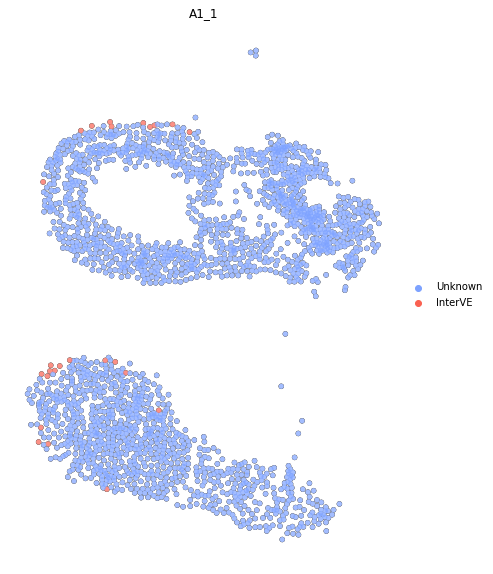

InvertVE cells: ['cell_37', 'cell_182', 'cell_201', 'cell_259', 'cell_290', 'cell_418', 'cell_437', 'cell_544', 'cell_627', 'cell_712', 'cell_723', 'cell_764', 'cell_1063', 'cell_1156', 'cell_1384', 'cell_1417', 'cell_1436', 'cell_1518', 'cell_1529', 'cell_1542', 'cell_1572', 'cell_1673', 'cell_1761', 'cell_2085', 'cell_2214']


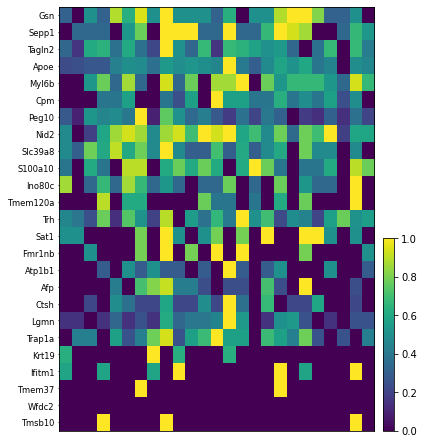

Processing D1_1 ...


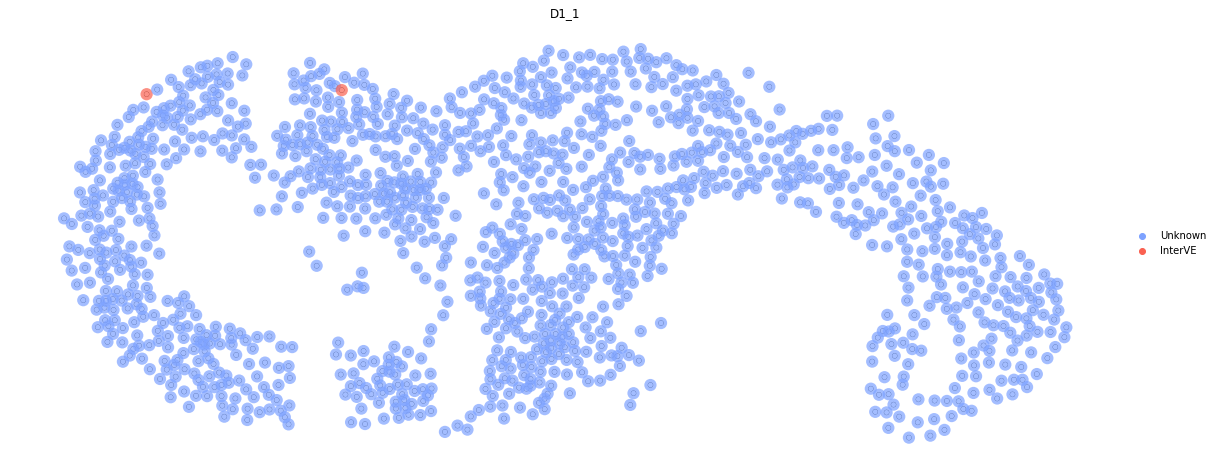

InvertVE cells: ['cell_26', 'cell_1170']


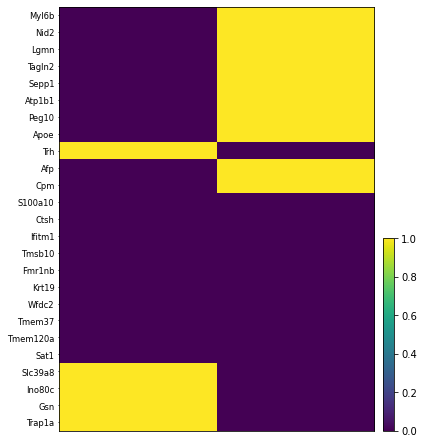

Processing D1_3 ...


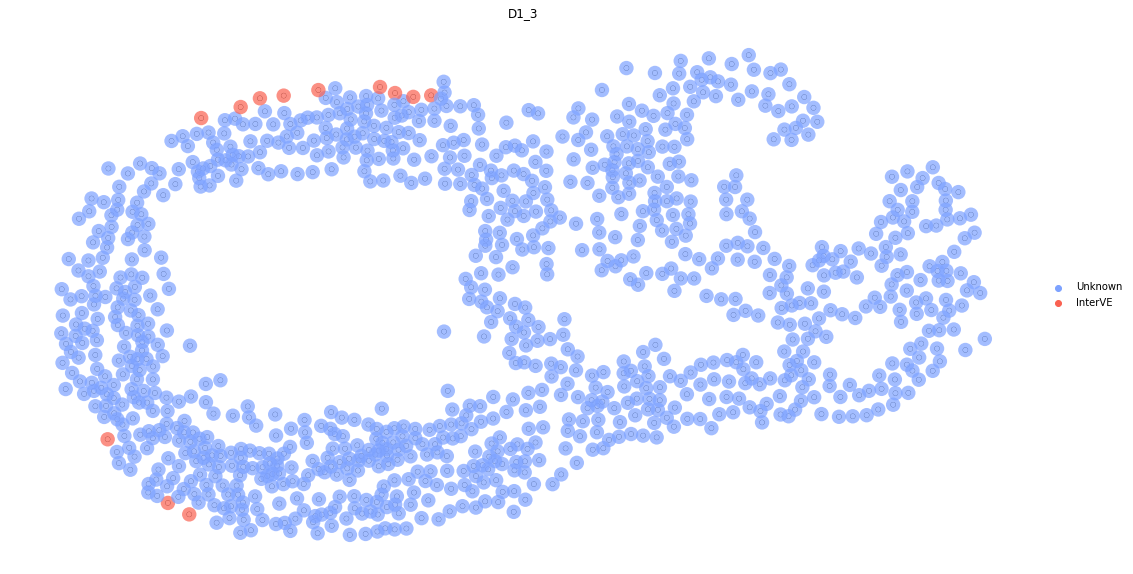

InvertVE cells: ['cell_130', 'cell_213', 'cell_370', 'cell_505', 'cell_544', 'cell_556', 'cell_611', 'cell_636', 'cell_644', 'cell_786', 'cell_806', 'cell_972']


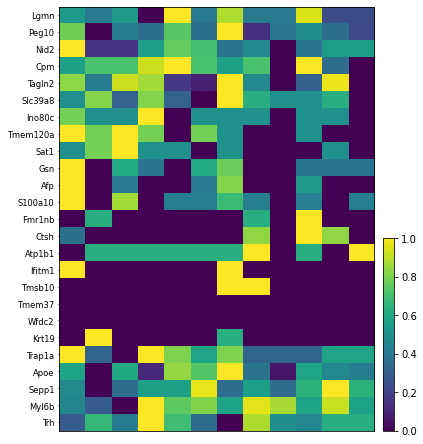

Processing B1_1 ...


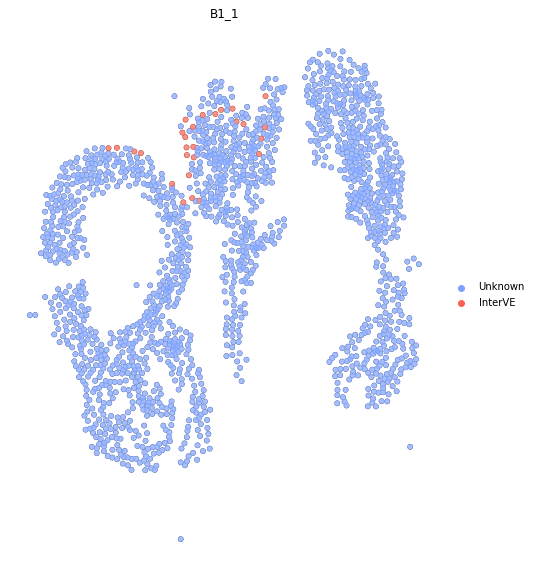

InvertVE cells: ['cell_110', 'cell_239', 'cell_370', 'cell_372', 'cell_393', 'cell_410', 'cell_460', 'cell_502', 'cell_545', 'cell_633', 'cell_655', 'cell_804', 'cell_823', 'cell_831', 'cell_837', 'cell_861', 'cell_868', 'cell_955', 'cell_1000', 'cell_1054', 'cell_1118', 'cell_1198', 'cell_1212', 'cell_1252', 'cell_1321', 'cell_1414', 'cell_1435']


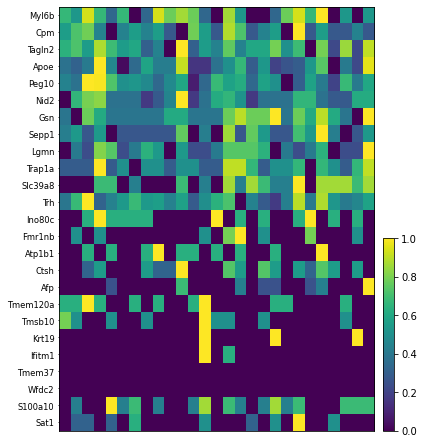

Processing D2 ...


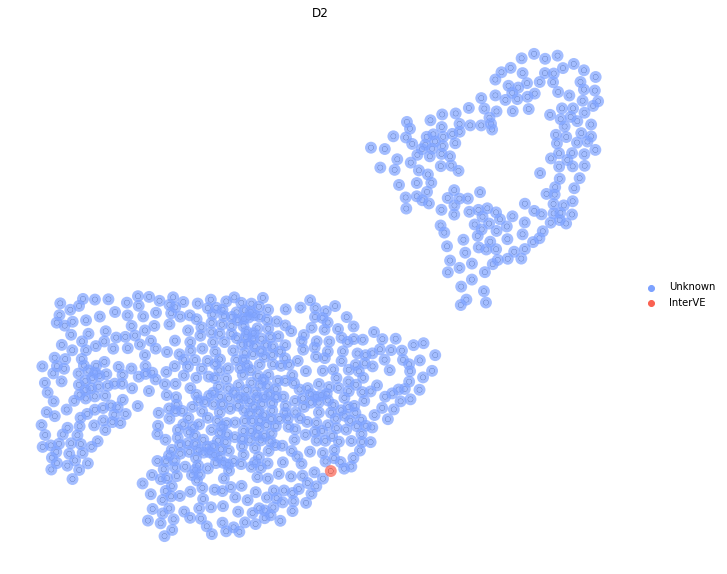

InvertVE cells: ['cell_653']


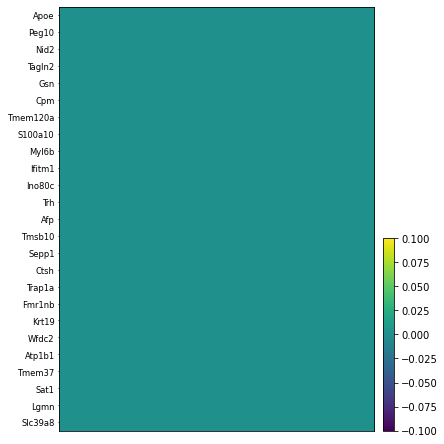

In [8]:
rcParams["figure.figsize"] = 20, 10

for folder_slice in slices:
    slice_name = os.path.basename(folder_slice)
    print(f"Processing {slice_name} ...")

    adata = load_object(folder_slice)
    adata = nzm(adata)
    adata.var_names = adata.var_names.str.replace("Selenop", "Sepp1")  # gene name fix
    adata = adata[:, spatial_genes].copy()

    spatial_labels = model.predict(adata.to_df())
    adata.obs["CellType"] = pd.Categorical(spatial_labels)
    adata.obs.CellType = adata.obs.CellType.cat.rename_categories(
        {0: "Unknown", 1: "InterVE"}
    )

    adata.uns["CellType_colors"] = ["#7da2ff", "#fa6151"]
    sc.pl.spatial(
        adata,
        color="CellType",
        spot_size=60,
        title=slice_name,
        frameon=False,
        add_outline=True,
        outline_width=[0.1, 0.4],
#         save=f"{slice_name}.svg",
    )
    interve = adata[adata.obs.CellType == "InterVE"]
    print(f"InvertVE cells: {list(interve.obs_names)}")

    # heatmap
    hclust = ward(pdist(interve.X.T))
    gene_order = interve.var_names[leaves_list(hclust)[::-1]]
    sc.pl.heatmap(
        interve,
        var_names=gene_order,
        standard_scale="var",
        groupby="CellType",
        swap_axes=True,
        figsize=[6, 8]
    )

In [9]:
!jupyter nbconvert --to html 11_dt_all.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 11_dt_all.ipynb to html
[NbConvertApp] Writing 580406 bytes to ../reports/11_dt_all.html
